# Solving Lunar Lander problem (Continuous version)

## PPO Implementation

### Useful packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from collections import deque, namedtuple

import torch
import torch.nn as nn
import torch.optim as optim

import gymnasium as gym
from tqdm import trange

### Useful functions

In [2]:
# Function to compute the running average of the last N elements of a vector x

def running_average(x, N):
    ''' 
    Function used to compute the running average of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
    else:
        y = np.zeros_like(x)
    return y

# pytorch-compatible density function for the 1-D distribution

def normal_pdf(x, mean, std_dev):
    factor = 1.0 / (torch.sqrt(2 * np.pi * std_dev))
    exponent = torch.exp(-((x - mean) ** 2) / (2 * std_dev))
    return factor * exponent

### Definition of our main classes (Replay buffer, Networks, etc)

In [3]:
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

class BaseAgent:
    def __init__(self, num_actions: int):
        self.num_actions = num_actions

    def forward(self, state: np.ndarray):
        pass

    def backward(self):
        pass

class ExperienceBuffer:
    def __init__(self, max_length):
        self.buffer = deque(maxlen=max_length)

    def add_experience(self, experience: Experience):
        self.buffer.append(experience)

    def __len__(self):
        return len(self.buffer)

    def sample_batch(self, batch_size):
        if batch_size > len(self.buffer):
            raise IndexError('Tried to sample too many elements from the buffer!')
        indices = np.random.choice(len(self.buffer), size=batch_size, replace=False)
        batch = [self.buffer[i] for i in indices]
        return zip(*batch)

# Define the Actor Network
class ActorNetwork(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super(ActorNetwork, self).__init__()
        self.input_layer = nn.Linear(input_dim, 400)
        self.mean_layer = nn.Linear(400, 200)
        self.mean_output = nn.Linear(200, output_dim)
        self.std_dev_layer = nn.Linear(400, 200)
        self.std_dev_output = nn.Linear(200, output_dim)
        
    def forward(self, x: torch.Tensor):
        x = torch.relu(self.input_layer(x))
        mean = torch.tanh(self.mean_output(torch.relu(self.mean_layer(x))))
        std_dev = torch.sigmoid(self.std_dev_output(torch.relu(self.std_dev_layer(x))))
        return mean, std_dev
    
# Define the Critic Network
class CriticNetwork(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super(CriticNetwork, self).__init__()
        self.input_layer = nn.Linear(input_dim, 400)
        self.hidden_layer = nn.Linear(400, 200)
        self.output_layer = nn.Linear(200, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.input_layer(x))
        x = torch.relu(self.hidden_layer(x))
        return self.output_layer(x)
    
class RandomAgent(BaseAgent):
    def __init__(self, num_actions: int):
        super(RandomAgent, self).__init__(num_actions)

    def forward(self, state: np.ndarray) -> np.ndarray:
        return np.clip(-1 + 2 * np.random.rand(self.num_actions), -1, 1)

### Hyperparameters

In [4]:
env = gym.make('LunarLanderContinuous-v3')

env.reset()

num_episodes = 1600
discount_factor = 0.99
running_avg_window = 50
num_actions = len(env.action_space.high)
state_dim = len(env.observation_space.high)
epsilon = 0.2
num_updates = 10
learning_rate_critic = 1e-3
learning_rate_actor = 1e-5
buffer_size = 10000

### Launch training

In [5]:
# Initialize reward and step lists
episode_rewards = []
episode_steps = []

# Fill up Buffer with Random experiences
agent = RandomAgent(num_actions)

# Create networks
actor = ActorNetwork(input_dim=state_dim, output_dim=num_actions)
critic = CriticNetwork(input_dim=state_dim, output_dim=1)

optimizer_actor = optim.Adam(actor.parameters(), lr=learning_rate_actor)
optimizer_critic = optim.Adam(critic.parameters(), lr=learning_rate_critic)

# Training Loop
progress_bar = trange(num_episodes, desc="Episode: ", leave=True)
for episode in progress_bar:
    
    buffer = ExperienceBuffer(max_length=buffer_size)
    total_reward = 0
    state, _ = env.reset()
    done = False
    time_step = 0
    
    rewards = []
    states = []
    actions = []
    
    while not done:
        # env.render() # Render the environment
        
        with torch.no_grad():
            states.append(state)
            mean, std_dev = actor(torch.tensor(np.array([state]), dtype=torch.float32))
            mean = mean.detach().numpy()
            std_dev = torch.sqrt(std_dev).detach().numpy()
            action = np.clip(np.random.normal(mean, std_dev), -1, 1).flatten()
            actions.append(action)

        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        rewards.append(reward)
        
        if len(rewards) > 1:
            for i in range(len(rewards)-1):
                rewards[i] += (discount_factor ** (time_step - i)) * reward

        total_reward += reward

        exp = Experience(state, action, reward, next_state, done)
        buffer.add_experience(exp)
    
        # Update state for next iteration
        state = next_state
        time_step += 1
    
    # Compute advantage and old_pi and Psi as targets for training
   
    rewards = torch.tensor(rewards, requires_grad=False, dtype=torch.float32)
    states = torch.tensor(np.array(states), requires_grad=True, dtype=torch.float32)
    actions = torch.tensor(np.array(actions), requires_grad=False, dtype=torch.float32)

    values = critic(states)
    values = torch.reshape(values, rewards.shape)
    advantages = rewards - values.detach()

    means, std_devs = actor(states)
    pdf1 = normal_pdf(actions[:, 0], means[:, 0], std_devs[:, 0])
    pdf2 = normal_pdf(actions[:, 1], means[:, 1], std_devs[:, 1])
    pi = pdf1 * pdf2
    old_pi = pi.detach()
    
    for iter in range(1, num_updates + 1):
        # Optimize Critic
        critic.train()
        values = critic(states)
        values = torch.reshape(values, rewards.shape)
        means, std_devs = actor(states)
        pdf1 = normal_pdf(actions[:, 0], means[:, 0], std_devs[:, 0])
        pdf2 = normal_pdf(actions[:, 1], means[:, 1], std_devs[:, 1])
        pi = pdf1 * pdf2
        loss_critic = nn.functional.mse_loss(values, rewards.detach())
        optimizer_critic.zero_grad()
        loss_critic.backward()
        nn.utils.clip_grad_norm_(critic.parameters(), max_norm=1.)
        optimizer_critic.step()
        
        # Optimize Actor
        ratio = torch.div(pi, old_pi)
        clipped_ratio = torch.max(
            torch.min(
                ratio, 
                torch.tensor(1 + epsilon, requires_grad=False, dtype=torch.float32)), 
            torch.tensor(1 - epsilon, requires_grad=False, dtype=torch.float32)
            )
        
        advantages = advantages.detach()
        actor.train()
        loss_actor = -torch.mean(torch.min(ratio * advantages, clipped_ratio * advantages))
        optimizer_actor.zero_grad()
        loss_actor.backward()
        nn.utils.clip_grad_norm_(actor.parameters(), max_norm=1.)
        optimizer_actor.step()
    
    # Add rewards and number of steps
    episode_rewards.append(total_reward)
    episode_steps.append(time_step)
    progress_bar.set_description("Episode {} - Reward/Steps: {:.1f}/{} - Avg. Reward/Steps: {:.1f}/{}".format(
        episode, 
        total_reward, 
        time_step, 
        running_average(episode_rewards, running_avg_window)[-1],
        running_average(episode_steps, running_avg_window)[-1]
        )
    )
env.close()

Episode 1599 - Reward/Steps: 19.1/133 - Avg. Reward/Steps: 213.0/240: 100%|██████████| 1600/1600 [17:51<00:00,  1.49it/s]    


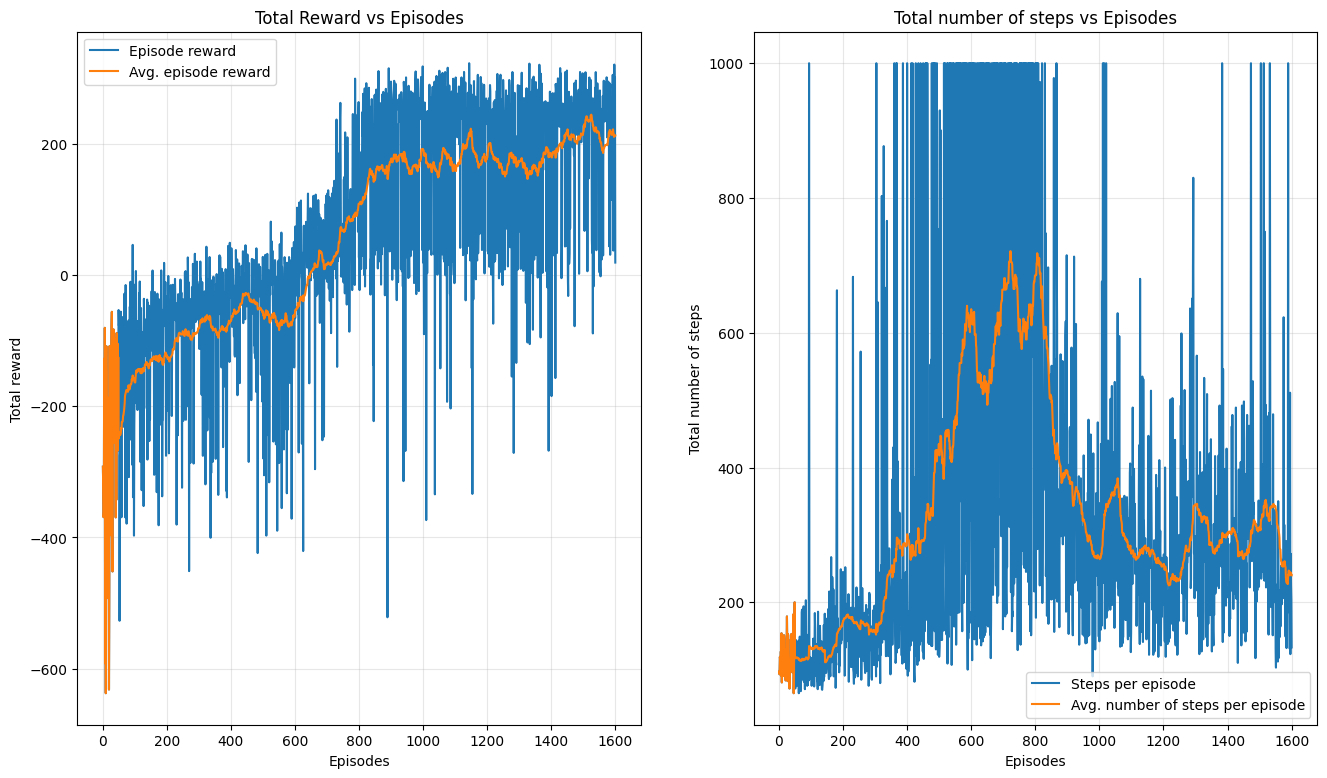

In [6]:
# Plot Rewards and steps

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))

ax[0].plot([i for i in range(1, num_episodes + 1)], episode_rewards, label='Episode reward')
ax[0].plot([i for i in range(1, num_episodes + 1)], running_average(
    episode_rewards, running_avg_window), label='Avg. episode reward')
ax[0].set_xlabel('Episodes')
ax[0].set_ylabel('Total reward')
ax[0].set_title('Total Reward vs Episodes')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot([i for i in range(1, num_episodes + 1)], episode_steps, label='Steps per episode')
ax[1].plot([i for i in range(1, num_episodes + 1)], running_average(
    episode_steps, running_avg_window), label='Avg. number of steps per episode')
ax[1].set_xlabel('Episodes')
ax[1].set_ylabel('Total number of steps')
ax[1].set_title('Total number of steps vs Episodes')
ax[1].legend()
ax[1].grid(alpha=0.3)

plt.show()

### Check Solution

Here we check the validity of our model. We achieve high performances with the above parameters (200+ average reward over 50 episodes)

In [8]:
# Load model
model = actor
print('Network model: {}'.format(model))

env = gym.make('LunarLanderContinuous-v3')
env.reset()

# Parameters
num_episodes = 50
confidence_threshold = 125

# Reward
episode_rewards = [] # Used to store episodes reward

# Simulate episodes
print('Checking solution...')

progress_bar = trange(num_episodes, desc='Episode: ', leave=True)
for i in trange(num_episodes, desc='Episode: ', leave=True):
    progress_bar.set_description("Episode {}".format(i))
    
    done = False
    state, _ = env.reset()
    total_reward = 0.0
    
    while not done:
        mean, std_dev = actor(torch.tensor(np.array([state]), dtype=torch.float32))
        mean = mean.detach().numpy()
        std_dev = torch.sqrt(std_dev).detach().numpy()

        action = np.clip(np.random.normal(mean, std_dev), -1, 1).flatten()  
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        total_reward += reward
        state = next_state

    episode_rewards.append(total_reward)
    env.close()

avg_reward = np.mean(episode_rewards)
confidence = np.std(episode_rewards) * 1.96 / np.sqrt(num_episodes)

print('Policy achieves an average total reward of {:.1f} +/- {:.1f} with confidence 95%.'.format(avg_reward, confidence))

if avg_reward - confidence > confidence_threshold or avg_reward + confidence > confidence_threshold:
    print('Your policy passed the test!')
else:
    print("Your policy did not pass the test! The average reward of your policy needs to be greater than {} with 95% confidence".format(confidence_threshold))

Network model: ActorNetwork(
  (input_layer): Linear(in_features=8, out_features=400, bias=True)
  (mean_layer): Linear(in_features=400, out_features=200, bias=True)
  (mean_output): Linear(in_features=200, out_features=2, bias=True)
  (std_dev_layer): Linear(in_features=400, out_features=200, bias=True)
  (std_dev_output): Linear(in_features=200, out_features=2, bias=True)
)
Checking solution...


Episode: 100%|██████████| 50/50 [01:04<00:00,  1.29s/it]

Policy achieves an average total reward of 233.9 +/- 22.0 with confidence 95%.
Your policy passed the test!
